In [1]:
from collections import defaultdict
import torch

import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.exposure import rescale_intensity
import os

from glob import glob

from tqdm.auto import tqdm

import hydra
from omegaconf import DictConfig, OmegaConf
import re
import yaml

import cv2

import imgviz
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet
import torch

import pandas as pd

import torchaudio
import pytorch_lightning as pl
from torch.optim import Adam
from pytorch_lightning import LightningModule
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
# from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random

from matplotlib import pyplot as plt
from tqdm import trange
import glob
import matplotlib.patches as mpatches 

define_nearest_crop = lambda x: int((x // 32) * 32)
is_img = re.compile('^.*.(jpg|jpeg|png|tif|tiff)', flags=re.IGNORECASE)

2024-05-31 21:45:22.225690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
NUM_CLASSES = 6

cl_to_name = {
  1: "железо",
  2: "рыболовные снасти", 
  3: "пластик",
  4: "дерево",
  5: "бетон",
  6: "резина" 
}

palette = {1: [255, 255, 255], 2: [0, 255, 255], 3: [0, 255, 0], 4: [255, 0, 0], 5: [255, 0, 255], 6: [255, 255, 0]}

palette_arr = np.zeros((6, 1, 3))
for i in range(1, 7):
    palette_arr[i-1, 0, ...] = palette[i]
    
palette_arr = palette_arr.astype(np.uint8)    

# plt.figure(figsize=(4, 10))
# plt.imshow(palette_arr)
# plt.show()

def combined_image(img, mask):
    """
    img: h x w x 3
    mask: h x w, значения - CLASSES (1, ..., 6), 0 - background
    """
    color_seg = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for label, color in palette.items():
        color_seg[mask == label, :] = color

    res = np.array(img) * 0.7 + color_seg * 0.3  # plot the image with the segmentation map
    res = res.astype(np.uint8)
    
    return res

def show_img_mask(img, mask, figsize=(16, 16), title=""):
    """
    img: h x w x 3
    mask: h x w, значения - CLASSES (1, ..., 6), 0 - background
    """
    res=combined_image(img, mask)
    
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(res)
    plt.legend(handles=ps) 
    plt.show()

In [3]:
train_names = """DJI_0090#rd#.jpeg
DJI_0090#lu#.jpeg
DJI_0710#ld#.jpeg
DJI_0160#ld#.jpeg
DJI_0560#ld#.jpeg
DJI_0590#ru#.jpeg
DJI_0070#lc#.jpeg
DJI_0064#rd#.jpeg
DJI_0130#cc#.jpeg
DJI_0570#ld#.jpeg
DJI_0700#cd#.jpeg
DJI_0060#ld#.jpeg
DJI_0560#cu#.jpeg
DJI_0540#ru#.jpeg
DJI_0530#cc#.jpeg
DJI_0660#lu#.jpeg
DJI_0660#lc#.jpeg
DJI_0056#cc#.jpeg
DJI_0040_#lc#.jpeg
DJI_0175#lu#.jpeg
DJI_0165#ld#.jpeg
DJI_0570#ru#.jpeg
DJI_0110#rd#.jpeg
DJI_0040#cd#.jpeg
DJI_0001#cd#.jpeg
DJI_0090#rc#.jpeg
DJI_0072#lu#.jpeg
DJI_0060#rd#.jpeg
DJI_0724#cc#.jpeg
DJI_0001#rc#.jpeg
DJI_0150#lu#.jpeg
DJI_0680#cu#.jpeg
DJI_0550#lu#.jpeg
DJI_0150#cc#.jpeg
DJI_0080_#rd#.jpeg
DJI_0530#rc#.jpeg
DJI_0170#lc#.jpeg
DJI_0080_#lc#.jpeg
DJI_0145#rc#.jpeg
DJI_0180#lc#.jpeg
DJI_0724#ld#.jpeg
DJI_0135#rc#.jpeg
DJI_0155#ld#.jpeg
DJI_0724#rc#.jpeg
DJI_0080_#cc#.jpeg
DJI_0660#ld#.jpeg
DJI_0630#cu#.jpeg
DJI_0700#rc#.jpeg
DJI_0570#rc#.jpeg
DJI_0720#cc#.jpeg
DJI_0145#rd#.jpeg
DJI_0600#cu#.jpeg
DJI_0010#rd#.jpeg
DJI_0710#cc#.jpeg
DJI_0530#lc#.jpeg
DJI_0180#cu#.jpeg
DJI_0720#cd#.jpeg
DJI_0090#cu#.jpeg
DJI_0724#ru#.jpeg
DJI_0670#cu#.jpeg
DJI_0170#ru#.jpeg
DJI_0180#ld#.jpeg
DJI_0056#rc#.jpeg
DJI_0550#lc#.jpeg
DJI_0660#rc#.jpeg
DJI_0155#rc#.jpeg
DJI_0610#ru#.jpeg
DJI_0135#cc#.jpeg
DJI_0620#ru#.jpeg
DJI_0600#ru#.jpeg
DJI_0175#cc#.jpeg
DJI_0180#cd#.jpeg
DJI_0550#rd#.jpeg
DJI_0560#ru#.jpeg
DJI_0580#ld#.jpeg
DJI_0150#lc#.jpeg
DJI_0640#rd#.jpeg
DJI_0080#rc#.jpeg
DJI_0165#rd#.jpeg
DJI_0040_#cc#.jpeg
DJI_0720#ld#.jpeg
DJI_0660#cd#.jpeg
DJI_0110#lu#.jpeg
DJI_0170#cc#.jpeg
DJI_0690#rc#.jpeg
DJI_0135#rd#.jpeg
DJI_0580#lc#.jpeg
DJI_0070#lu#.jpeg
DJI_0135#lc#.jpeg
DJI_0110#rc#.jpeg
DJI_0540#rc#.jpeg
DJI_0072#cc#.jpeg
DJI_0590#cu#.jpeg
DJI_0160#lu#.jpeg
DJI_0064#lc#.jpeg
DJI_0580#rd#.jpeg
DJI_0048#cu#.jpeg
DJI_0135#ld#.jpeg
DJI_0155#cc#.jpeg
DJI_0680#ld#.jpeg
DJI_0130#ru#.jpeg
DJI_0160#cc#.jpeg
DJI_0040_#lu#.jpeg
DJI_0140#cd#.jpeg
DJI_0048#lc#.jpeg
DJI_0180#lu#.jpeg"""

In [4]:
train_imgs = train_names.split('\n')

### Подготовка датасета

In [5]:
import random
random.seed(42)

In [6]:
def filter_by_indices(images_pathes, masks_pathes, indices):
    res_imgs = []
    res_masks = []
    for i, (img, mask) in enumerate(zip(images_pathes, masks_pathes)):
        if i in indices:
            res_imgs.append(img)
            res_masks.append(mask)
            
    return res_imgs, res_masks

def get_generated_pathes():
    masks_path = "/home/jupyter/datasphere/s3/garbage-data/BEST_GENERATED_DATA/334311_classes_balance/*"
    #masks_path = "/home/jupyter/datasphere/datasets/generated_after_sam_markup/generated_after_sam_markup/*"
    pathes = sorted(glob.glob(masks_path))
    
    images_pathes = []
    masks_pathes = []
    
    for path in pathes:
        images_pathes.append(f"{path}/image.jpeg")
        
        d = {}
        for cl in range(NUM_CLASSES):
            d[cl] = f"{path}/class_{cl}.png"
        masks_pathes.append(d)
        
    return images_pathes, masks_pathes


def get_pathes(indices=[]):    
    """
    подразумевается, что маски .png, изображения .jpg, имена файлов одинаковые для изображений и масок
    маски присутствуют для всех классов
    """
    masks_path = "/home/jupyter/datasphere/s3/garbage-data/generated-data/dataset_roman_last_version/class_{}"
    images_path = '/home/jupyter/datasphere/s3/garbage-data/generated-data/disk_full_images/{}'
    
    class2image = {} 

    for cl in range(NUM_CLASSES):
        class2image[cl] = sorted(glob.glob(masks_path.format(cl) + '/**/*.png', recursive=True))
        
    masks_pathes = []
    
    for i in range(len(class2image[0])):
        d = {}
        for cl in range(NUM_CLASSES):
            d[cl] = class2image[cl][i]
        masks_pathes.append(d)
        
    postfixes = [os.path.basename(f) for f in class2image[0]]
    images_pathes = [images_path.format(postfix)[:-3] + 'jpeg' for postfix in postfixes]
    
    if len(indices) > 0:
        return filter_by_indices(images_pathes, masks_pathes, indices) 
    return images_pathes, masks_pathes

def get_generated_stargan_pathes():
    masks_path = "/home/jupyter/datasphere/s3/garbage-data/BEST_GENERATED_DATA/generated_with_stargan_after_sam_markup/*"
    pathes = sorted(glob.glob(masks_path))
    
    images_pathes = []
    masks_pathes = []
    
    for path in pathes:
        for i in range(11):
            images_pathes.append(f"{path}/image_{i}.jpeg")
        
            d = {}
            for cl in range(NUM_CLASSES):
                d[cl] = f"{path}/mask_{cl}.png"
            masks_pathes.append(d)
        
    return images_pathes, masks_pathes


images_pathes, masks_pathes= get_pathes()
print(len(images_pathes))
print(len(masks_pathes))

gen_images_pathes, gen_masks_pathes = get_generated_pathes()
print(len(gen_images_pathes))
print(len(gen_masks_pathes))

gen_stargan_images_pathes, gen_stargan_masks_pathes = get_generated_stargan_pathes()
print(len(gen_stargan_images_pathes))
print(len(gen_stargan_masks_pathes))

446
446
1500
1500
451000
451000


In [7]:
ps = []
for cl, name in cl_to_name.items():
    p = mpatches.Patch(color=tuple(np.array(palette[cl]) / 255.), label=name) 
    ps.append(p)
    
import scipy.ndimage as ndimage

def _load_image(img_addr):
    img = cv2.imread(img_addr)
    if img is None:
        return None, False
    # img = img[:define_nearest_crop(img.shape[0]), :define_nearest_crop(img.shape[1]), ...]
    return img, True

def mask_by_threshold(mask, threshold):
    mask_th = np.zeros_like(mask)
    mask_th[mask >= threshold] = 255
    return mask_th

In [8]:
import time

from skimage import io, color

# def rgb2lab(center):
#     return color.rgb2lab([[center/255]])[0][0]

def center_diff(c1, c2):
    return np.sqrt(np.sum((c1 - c2) ** 2))

def separate_objects_masks(mask):
    """
    mask: должна содержать только значиния 0 и 255, 
    h x w x 3, все 3 канала одинаково заполнены  
    """
    res = []
    
    label_im, nb_labels = ndimage.label(mask) 
    
    for i in range(nb_labels):
        mask_compare = np.full(np.shape(label_im), i+1) 
        separate_mask = np.equal(label_im, mask_compare).astype(int) 
        separate_mask[separate_mask == 1] = 255
        res.append(separate_mask)
    return res


def filter_small_objects(mask, threshold=70):
    label_im, nb_labels = ndimage.label(mask) 
    
    unique, counts = np.unique(label_im, return_counts=True)
    filtered_mask = np.zeros_like(mask).astype(np.uint8)
    
    for val, cnt in zip(unique, counts):
        if val == 0:
            continue 
        if cnt < threshold:
            continue 
        filtered_mask += ((label_im == val) * 255).astype(np.uint8)
    return filtered_mask


def make_clusterization(img, mask, k=3):
    """
    mask: должна содержать только значиния 0 и 255, 
    h x w x 3, все 3 канала одинаково заполнены  
    k - число кластеров
    
    img: лучше в LAB, чем в RGB, h x w x 3
    
    Returns:
    centers: k x 3
    labels: h x w, заполненное значениями от 0 до k - 1
    """
     # зануляем всё, что не покрыто маской
    masked_img = np.where(mask == 255, img, np.zeros_like(img))
    pixel_values = masked_img.reshape((-1, 3))
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 6, 0.001)
    _, labels, (centers) = cv2.kmeans(np.float32(pixel_values), k, None, criteria, 6, cv2.KMEANS_RANDOM_CENTERS)
    
    labels = labels.reshape(masked_img.shape[:-1])
    
    return centers, labels

def label_out_mask(mask, labels):
    """
    возвращает label, относящийся к пространству вне маски
    """
    cnts_out = {label: 0 for label in np.unique(labels)}
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j][0] != 255:
                label = labels[i][j]
                cnts_out[label] += 1
    
    # самый частый label вне маски - label, относящийся к зоне вне маски
    max_cnt = None
    forbidden_l = None
    for l, cnt in cnts_out.items():
        if max_cnt is None or cnt > max_cnt:
            max_cnt = cnt
            forbidden_l = l
    return forbidden_l

def mask_from_labels(mask, labels, selected):
    new_mask = np.zeros_like(mask)
    for label in selected:
        new_mask[labels == label] = 255
        
    masked_new_mask = np.where(mask == 255, new_mask, np.zeros_like(new_mask))
    return masked_new_mask


# идея:
# выбрать label, который больше пересекается с более уверенной маской 
def choose_label_by_relative_proportion(mask, stronger_mask, labels, labels_list, centers):
    """
    mask, stronger_mask: должны содержать только значиния 0 и 255, 
    h x w x 3, все 3 канала одинаково заполнены  
    
    labels: h x w
    labels_list - cписок label-ов, из которых выбираем 
    """
    max_proportion = None
    chosen_label = None
    
#     plt.figure(figsize=(20, 20))
#     plt.title(f"stronger mask")
#     plt.imshow(np.uint8(img * 0.6 + stronger_mask * [[[1, 0, 0]]] * 0.4))
#     plt.show()
    
    for label in labels_list:
        
        label_m = np.where(labels == label, mask[..., 0], np.zeros_like(mask)[..., 0])
        intersection_stronger_mask_label = np.where(label_m == 255, stronger_mask[..., 0], np.zeros_like(stronger_mask[..., 0]))
        
        # plt.figure(figsize=(20, 20))
        # plt.title(f"intersection with stronger mask")
        # plt.imshow(np.uint8(img * 0.6 + np.stack([intersection_stronger_mask_label , intersection_stronger_mask_label, intersection_stronger_mask_label], axis=2) * [[[1, 0, 0]]] * 0.4))
        # plt.show()
        
        proportion = 0.0
        if np.sum(stronger_mask == 255) > 0:
            proportion = np.sum(intersection_stronger_mask_label == 255) / np.sum(stronger_mask == 255)
        # print(f"center: {centers[label]}, proportion: {proportion}")
        
        if max_proportion is None or proportion > max_proportion:
            max_proportion = proportion
            chosen_label = label
    
    return chosen_label

# идея:
# взять средний цвет у внешности маски
# и выбрать цвет, который больше с ним различается
def choose_label_by_out_color_diff(m, dilated_mask, centers, forbidden_labels, img_lab):
    out_mask = np.where(m == 255, np.zeros_like(m), dilated_mask)
    out_mask_img = np.where(out_mask == 255, img_lab, np.zeros_like(img_lab))
    out_mask_center = out_mask_img.sum(axis=(0, 1)) / np.sum(out_mask == 255, axis=(0, 1))
    
    # print(f"Out mask center: {out_mask_center}")
    # plt.figure(figsize=(2, 2))
    # plt.imshow(cv2.cvtColor(np.uint8([[out_mask_center]]), cv2.COLOR_LAB2BGR))
    # plt.show()

    max_diff = None
    chosen_label = None

    for i, c in enumerate(centers):
        if i not in forbidden_labels:
            diff = center_diff(c, out_mask_center)
            # print(f"center: {c}, diff: {diff}")                
            if max_diff is None or max_diff < diff:
                max_diff = diff
                chosen_label = i
                
    return chosen_label


def choose_label_by_relative_proportion_prev(mask, stronger_mask, labels, labels_list):
    """
    mask, stronger_mask: должны содержать только значиния 0 и 255, 
    h x w x 3, все 3 канала одинаково заполнены  
    
    labels: h x w
    labels_list - cписок label-ов, из которых выбираем 
    """
    max_proportion = None
    chosen_label = None
    for label in labels_list:
        label_m = np.where(labels == label, mask[..., 0], np.zeros_like(mask)[..., 0])
        intersection_stronger_mask_label = np.where(label_m == 255, stronger_mask[..., 0], np.zeros_like(stronger_mask[..., 0]))
        proportion = np.sum(intersection_stronger_mask_label == 255) / np.sum(labels == label)
        if max_proportion is None or proportion > max_proportion:
            max_proportion = proportion
            chosen_label = label
    
    return chosen_label


def choose_label_by_out_intersection(img, m, dilated_mask, labels, labels_list):
    """
    mask, out_mask: должны содержать только значиния 0 и 255, 
    h x w x 3, все 3 канала одинаково заполнены  
    
    labels: h x w
    labels_list - cписок label-ов, из которых выбираем 
    """
    out_mask = np.where(m == 255, np.zeros_like(dilated_mask), dilated_mask)
    
    min_val = None
    min_label = None
    for label in labels_list:
        label_m = np.where(labels == label, dilated_mask[..., 0], np.zeros_like(dilated_mask)[..., 0])
        
#         plt.figure(figsize=(20, 20))
#         plt.imshow(np.uint8(img * 0.6 + np.stack([label_m, label_m, label_m], axis=2) * 0.4))
#         plt.show()
        
        intersection_out_mask_label = np.where(label_m == 255, out_mask[..., 0], np.zeros_like(out_mask)[..., 0])
        
        v = np.stack([intersection_out_mask_label, intersection_out_mask_label, intersection_out_mask_label], axis=2)
        
#         print("Intersection with out")
#         plt.figure(figsize=(20, 20))
#         plt.imshow(np.uint8(img * 0.6 + v * 0.4))
#         plt.show()
        
        val = np.sum(intersection_out_mask_label == 255)
        
#         print(f"Intersection: {val}")
        
        if min_val is None or val < min_val:
            min_val = val
            min_label = label
    
    return min_label

def select_forbidden_labels(centers, labels, mask):
    forbidden_labels = []
    for i, c in enumerate(centers):
            if np.sum(c) == 0:
                forbidden_labels.append(i)
    if len(forbidden_labels) == 0:
        forbidden_label = label_out_mask(mask, labels)
        forbidden_labels.append(forbidden_label)
        
    return forbidden_labels
    

def improve_mask_prev(img, mask):
    # start = time.time()
    
    # добавляем blur, чтобы избавиться от лишнего шума
    blur = cv2.GaussianBlur(src=img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
    # переводим в LAB, так как в этом пространстве эвклидова метрика лучше соотносится с perceptual difference
    # человеческого восприятия
    img_lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
    result_mask = np.zeros_like(mask).astype(np.uint8)
    
    # print(f"cvtColor time consumed: {time.time() - start}")
    # start = time.time()
    
    threshold1 = 50
    threshold2 = 200

    mask_th1 = mask_by_threshold(mask, threshold1)
    mask_th2 = mask_by_threshold(mask, threshold2)

    # отдельные маски для каждого объекта
    separate_masks = separate_objects_masks(mask_th1)
    
    kernel = np.ones((5,5),np.uint8)
    
    # print(f"separate masks time consumed: {time.time() - start}")
    
    for m in separate_masks:
        # it_start = time.time()
        
        centers, labels = make_clusterization(img_lab, m)
        
        # print(f"it clust time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # print(f"centers: {centers}")
        forbidden_labels = select_forbidden_labels(centers, labels, m)

        labels_list = list(filter(lambda l: l not in forbidden_labels, list(np.unique(labels))))
        
        
#         for label in labels_list:
#             new_mask = mask_from_labels(dilated_mask, labels, [label])
#             plt.figure(figsize=(2, 2))
#             plt.title(f"center: {centers[label]}")
#             plt.imshow(cv2.cvtColor(np.uint8([[centers[label]]]), cv2.COLOR_LAB2BGR))
#             plt.show()
            
#             plt.figure(figsize=(20, 20))
#             plt.title(f"mask for center: {centers[label]}")
#             plt.imshow(np.uint8(img * 0.6 + new_mask * [[[1, 0, 0]]] * 0.4))
#             plt.show()

        # print(f"it select forbidden label time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # print(f"it choose_label_by_out_color_diff time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # chosen_label2 = choose_label_by_out_intersection(img, m, dilated_mask, labels, labels_list)
        
        stronger_mask = np.where(m == 255, mask_th2, np.zeros_like(mask_th2))
        
        chosen_label2 = choose_label_by_relative_proportion_prev(m, stronger_mask, labels, labels_list)
        
        # print(f"it choose_label_by_relative_proportion time consumed: {time.time() - it_start}")
        # it_start = time.time()

        chosen_labels = [chosen_label2]
        new_mask = mask_from_labels(m, labels, chosen_labels)
        
        # print(f"it select label time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # print("Chosen mask")
        # plt.figure(figsize=(20, 20))
        # plt.imshow(np.uint8(img * 0.6 + new_mask * [[[1, 0, 0]]] * 0.4))
        # plt.show()
        
        result_mask += filter_small_objects(new_mask).astype(np.uint8)
        
        # print(f"it filter small objects time consumed: {time.time() - it_start}")
    
    # added dilation and gaussian blur
    kernel = np.ones((3,3),np.uint8)
    dilated = cv2.dilate(result_mask, kernel, iterations=3)
    blurred = cv2.GaussianBlur(src=dilated, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
    return blurred.astype(np.uint8)


def improve_mask(img, mask):
    # start = time.time()
    
    # добавляем blur, чтобы избавиться от лишнего шума
    blur = cv2.GaussianBlur(src=img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
    # переводим в LAB, так как в этом пространстве эвклидова метрика лучше соотносится с perceptual difference
    # человеческого восприятия
    img_lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
    result_mask = np.zeros_like(mask).astype(np.uint8)
    
    # print(f"cvtColor time consumed: {time.time() - start}")
    # start = time.time()
    
    threshold1 = 50
    threshold2 = 200

    mask_th1 = mask_by_threshold(mask, threshold1)
    mask_th2 = mask_by_threshold(mask, threshold2)

    # отдельные маски для каждого объекта
    separate_masks = separate_objects_masks(mask_th1)
    
    kernel = np.ones((5,5),np.uint8)
    
    # print(f"separate masks time consumed: {time.time() - start}")
    
    for m in separate_masks:
        # it_start = time.time()
        
        # граница вокруг маски
        dilated_mask = cv2.dilate(m.astype(np.uint8), kernel, iterations=10)
        
        centers, labels = make_clusterization(img_lab, m)
        
        # print(f"it clust time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # print(f"centers: {centers}")
        forbidden_labels = select_forbidden_labels(centers, labels, m)

        labels_list = list(filter(lambda l: l not in forbidden_labels, list(np.unique(labels))))
        
        
#         for label in labels_list:
#             new_mask = mask_from_labels(dilated_mask, labels, [label])
#             plt.figure(figsize=(2, 2))
#             plt.title(f"center: {centers[label]}")
#             plt.imshow(cv2.cvtColor(np.uint8([[centers[label]]]), cv2.COLOR_LAB2BGR))
#             plt.show()
            
#             plt.figure(figsize=(20, 20))
#             plt.title(f"mask for center: {centers[label]}")
#             plt.imshow(np.uint8(img * 0.6 + new_mask * [[[1, 0, 0]]] * 0.4))
#             plt.show()

        # print(f"it select forbidden label time consumed: {time.time() - it_start}")
        # it_start = time.time()

        chosen_label1 = choose_label_by_out_color_diff(m, dilated_mask, centers, forbidden_labels, img_lab)
        
        # print(f"it choose_label_by_out_color_diff time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # chosen_label2 = choose_label_by_out_intersection(img, m, dilated_mask, labels, labels_list)
        
        stronger_mask = np.where(m == 255, mask_th2, np.zeros_like(mask_th2))
        chosen_label2 = choose_label_by_relative_proportion(m, stronger_mask, labels, labels_list, centers)
        
        # print(f"it choose_label_by_relative_proportion time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        if chosen_label1 == chosen_label2:
            chosen_labels = [chosen_label1]
        else:
            chosen_labels = [chosen_label1, chosen_label2]
        # print(f"chosen labels: {chosen_labels}")
            
        new_mask = mask_from_labels(m, labels, chosen_labels)
        
        # print(f"it select label time consumed: {time.time() - it_start}")
        # it_start = time.time()
        
        # print("Chosen mask")
        # plt.figure(figsize=(20, 20))
        # plt.imshow(np.uint8(img * 0.6 + new_mask * [[[1, 0, 0]]] * 0.4))
        # plt.show()
        
        result_mask += filter_small_objects(new_mask).astype(np.uint8)
        
        # print(f"it filter small objects time consumed: {time.time() - it_start}")
        
    
    # added dilation and gaussian blur
    kernel = np.ones((3,3),np.uint8)
    dilated = cv2.dilate(result_mask, kernel, iterations=3)
    blurred = cv2.GaussianBlur(src=dilated, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
    
    return blurred.astype(np.uint8)

def improve_mask_simple(img, mask):
    start = time.time()
    
    # добавляем blur, чтобы избавиться от лишнего шума
    blur = cv2.GaussianBlur(src=img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
    # переводим в LAB, так как в этом пространстве эвклидова метрика лучше соотносится с perceptual difference
    # человеческого восприятия
    img_lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
    result_mask = np.zeros_like(mask).astype(np.uint8)
    
    print(f"cvtColor time consumed: {time.time() - start}")
    start = time.time()
    
    threshold1 = 50
    threshold2 = 200

    mask_th1 = mask_by_threshold(mask, threshold1)
    mask_th2 = mask_by_threshold(mask, threshold2)

    it_start = time.time()    
    m = mask_th1    
    
    kernel = np.ones((5,5),np.uint8)
    # граница вокруг маски
    dilated_mask = cv2.dilate(m.astype(np.uint8), kernel, iterations=10)

    centers, labels = make_clusterization(img_lab, dilated_mask) # m

    print(f"clust time consumed: {time.time() - it_start}")
    it_start = time.time()

    # print(f"centers: {centers}")
    forbidden_labels = select_forbidden_labels(centers, labels, m)

    labels_list = list(filter(lambda l: l not in forbidden_labels, list(np.unique(labels))))

#         for label in labels_list:
#             new_mask = mask_from_labels(dilated_mask, labels, [label])
#             plt.figure(figsize=(2, 2))
#             plt.title(f"center: {centers[label]}")
#             plt.imshow(cv2.cvtColor(np.uint8([[centers[label]]]), cv2.COLOR_LAB2BGR))
#             plt.show()

#             plt.figure(figsize=(20, 20))
#             plt.title(f"mask for center: {centers[label]}")
#             plt.imshow(np.uint8(img * 0.6 + new_mask * [[[1, 0, 0]]] * 0.4))
#             plt.show()

    print(f"select forbidden label time consumed: {time.time() - it_start}")
    it_start = time.time()

    chosen_label1 = choose_label_by_out_color_diff(m, dilated_mask, centers, forbidden_labels, img_lab)

    print(f"choose_label_by_out_color_diff time consumed: {time.time() - it_start}")
    it_start = time.time()

    stronger_mask = np.where(m == 255, mask_th2, np.zeros_like(mask_th2))
    chosen_label2 = choose_label_by_relative_proportion(m, stronger_mask, labels, labels_list, centers)

    print(f"choose_label_by_relative_proportion time consumed: {time.time() - it_start}")
    it_start = time.time()

    if chosen_label1 == chosen_label2:
        chosen_labels = [chosen_label1]
    else:
        chosen_labels = [chosen_label1, chosen_label2]

    new_mask = mask_from_labels(m, labels, chosen_labels)
    
    filtered = filter_small_objects(new_mask).astype(np.uint8)
    
    print(f"filter_small_objects time consumed: {time.time() - it_start}")
    it_start = time.time()
    
    # added dilation and gaussian blur
    kernel = np.ones((3,3),np.uint8)
    dilated = cv2.dilate(filtered, kernel, iterations = 1)
    blurred = cv2.GaussianBlur(src=dilated, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5) 
    return blurred.astype(np.uint8)

In [9]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH='sam_vit_h_4b8939.pth' # здесь может быть использована другая модель, например, sam_vit_h_4b8939.pth, sam_hq_vit_h.pth
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [10]:
def not_improved(img, mask_path):
    # не обрабатываем пустые
    flag = False
    for cl in range(NUM_CLASSES):
        m, ok = _load_image(mask_path[cl])
        if not ok:
            continue
        if len(np.unique(np.array(m))) > 1:
            flag = True
            break
            
    if not flag:
        return None
    
    masks = {}
    improved_masks = {}
    
    for cl in range(NUM_CLASSES):
        m, ok = _load_image(mask_path[cl])
        if not ok:
            continue

        if len(np.unique(np.array(m))) > 1:
            improved_masks[cl] = mask_by_threshold(m, 50) 

    improved_mask = np.zeros_like(img)
    if len(improved_masks) == 0:
        return None

    for cl in range(NUM_CLASSES):
        if cl in improved_masks:
            im_cl_mask = improved_masks[cl]
            
            # защищаемся от того, что несколько классов могут быть у одного объекта            
            im_cl_mask = np.where(improved_mask == 0, im_cl_mask, np.zeros_like(im_cl_mask))
            improved_mask += np.where(im_cl_mask == 255, np.ones_like(img) * (cl + 1), np.zeros_like(img))
            
    assert np.sum(improved_mask >= 7) == 0
    # оставляем только один канал
    improved_mask = improved_mask[:, :, 0]
    mask = improved_mask
    
    return mask


def improve_by_sam(img, mask_path, filter_small=False):
    # не обрабатываем пустые
    flag = False
    for cl in range(NUM_CLASSES):
        m, ok = _load_image(mask_path[cl])
        if not ok:
            continue
        if len(np.unique(np.array(m))) > 1:
            flag = True
            break
            
    if not flag:
        return None
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_predictor.set_image(img_rgb)
    
    masks = {}
    improved_masks = {}
    
    for cl in range(NUM_CLASSES):
        m, ok = _load_image(mask_path[cl])
        if not ok:
            continue

        if len(np.unique(np.array(m))) > 1:
            improved_masks[cl] = improve_mask_by_sam(mask_predictor, m, filter_small=filter_small) 

    improved_mask = np.zeros_like(img)
    if len(improved_masks) == 0:
        return None

    for cl in range(NUM_CLASSES):
        if cl in improved_masks:
            im_cl_mask = improved_masks[cl]
            
            # защищаемся от того, что несколько классов могут быть у одного объекта            
            im_cl_mask = np.where(improved_mask == 0, im_cl_mask, np.zeros_like(im_cl_mask))
            improved_mask += np.where(im_cl_mask == 255, np.ones_like(img) * (cl + 1), np.zeros_like(img))
            
    assert np.sum(improved_mask >= 7) == 0
    # оставляем только один канал
    improved_mask = improved_mask[:, :, 0]
    mask = improved_mask
    
    return mask
    

def select_n_random_points_in_mask(mask, n=10):
    """
    выбирает n точек, для которых значение равно 255
    """
    m = mask[..., 0]
    ind = np.where(m == 255)
    labels = np.dstack((ind[1], ind[0]))[0]
    return np.random.permutation(labels)[:n]

def improve_mask_by_sam(mask_predictor, mask, filter_small):
    input_labels = []
    input_points = []

    threshold1 = 50
    threshold2 = 200

    mask_th1 = mask_by_threshold(mask, threshold1)
    mask_th2 = mask_by_threshold(mask, threshold2)
    
    kernel = np.ones((5,5),np.uint8)
    small_dilated_mask = cv2.dilate(mask_th1.astype(np.uint8), kernel, iterations=1)
    big_dilated_mask = cv2.dilate(mask_th1.astype(np.uint8), kernel, iterations=10)
    out_mask = np.where(mask_th1 == 255, np.zeros_like(big_dilated_mask), big_dilated_mask)
    out_dilated_mask = np.where(big_dilated_mask == 255, np.zeros_like(big_dilated_mask), big_dilated_mask)
    
    true_labels = select_n_random_points_in_mask(mask_th2, n=40)
    false_labels = select_n_random_points_in_mask(out_mask, n=50)
    false_random_labels = select_n_random_points_in_mask(out_mask, n=50)

    input_points = np.concatenate([true_labels, false_labels, false_random_labels])
    input_labels = np.array([1] * len(true_labels) + [0] * (len(false_labels) + len(false_random_labels)))
    
    masks, _, _ = mask_predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=False)
    sam_mask=masks[0]
    res = np.zeros_like(mask)
    res[sam_mask, ...] = [255, 0, 0]
    masked_new_mask = np.where(small_dilated_mask == 255, res, np.zeros_like(res))
    
    if filter_small:
        masked_new_mask = filter_small_objects(masked_new_mask)
    
    return masked_new_mask

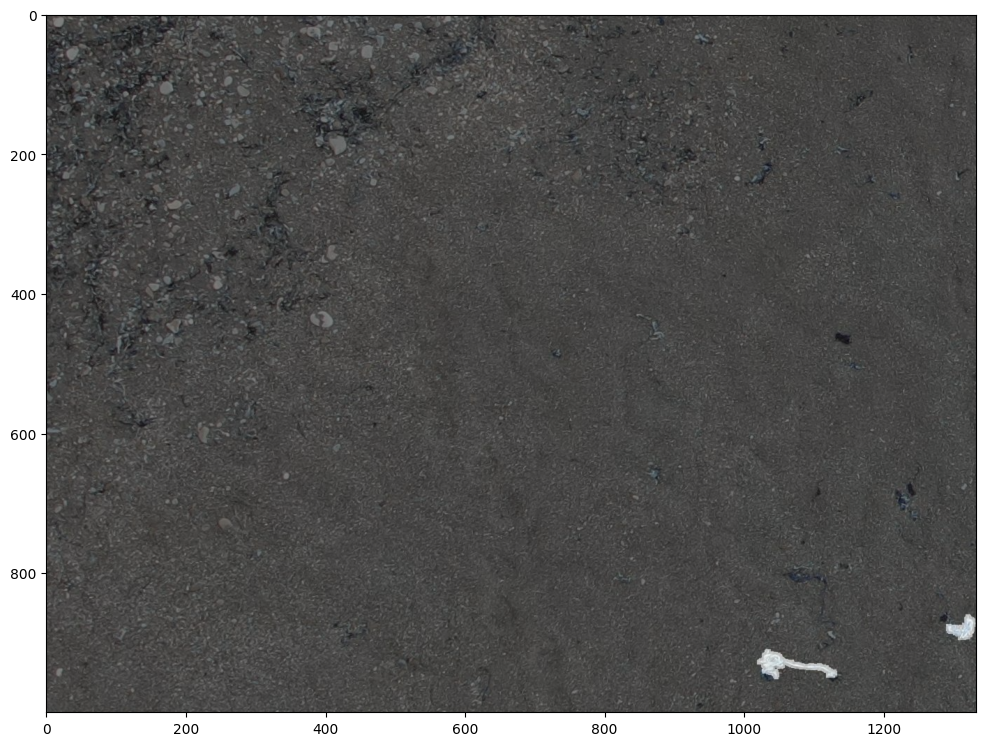

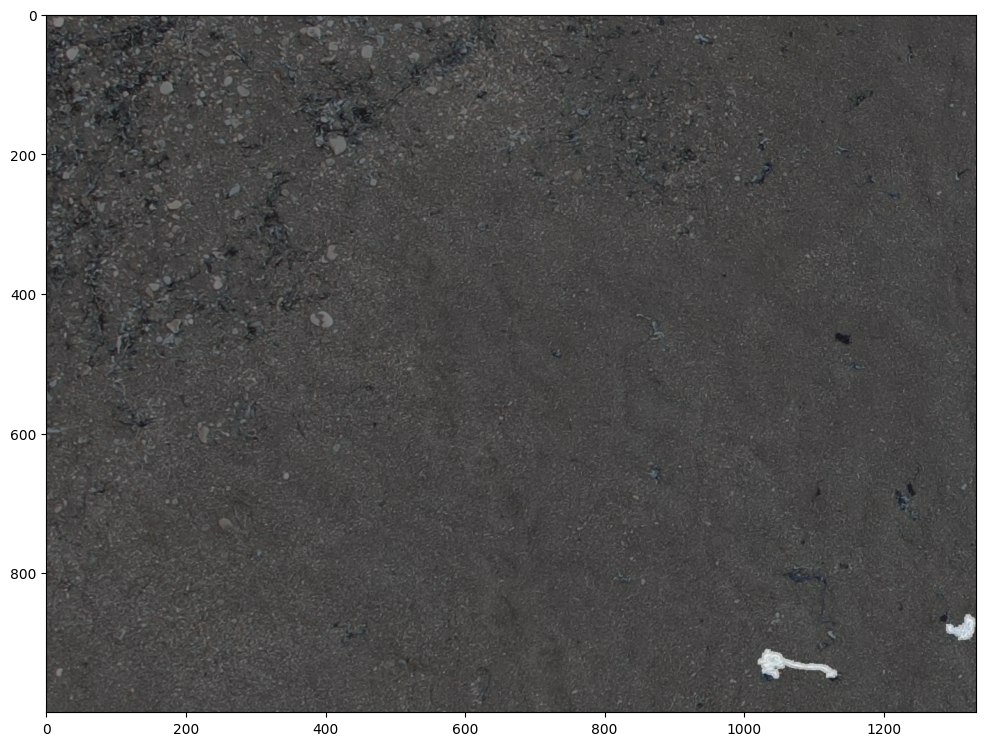

In [11]:
ind = 2

image_path, mask_path = images_pathes[ind], masks_pathes[ind]
img, ok = _load_image(image_path)
mask, ok = _load_image(mask_path[1])

new_mask = improve_mask(img, mask) 
plt.figure(figsize=(12, 12))
plt.imshow(np.uint8(img * 0.5 + new_mask * 0.5))
plt.show()

new_mask = improve_mask_prev(img, mask) 
plt.figure(figsize=(12, 12))
plt.imshow(np.uint8(img * 0.5 + new_mask * 0.5))
plt.show()

In [12]:
correct_indices = [2, 10, 33,  36, 39, 47, 56, 93, 94, 108, 109, 112, 126, 128, 129, 131, 136, 138, 149, 155, 158, 164, 175, 181, 185, 187, 190, 192, 199, 202, 203, 208, 215, 220, 223, 225, 226, 229, 234, 235, 238, 242, 243, 244, 253, 254, 255, 262,  270, 275, 277, 282, 283, 285, 288, 291, 296, 299, 303, 304, 307, 308, 310, 312, 315, 316, 317, 319, 320, 324, 327, 330, 333, 336, 339, 348, 350, 354, 357, 359, 361, 364, 365, 367, 371,  376, 379, 382, 384, 385, 386, 387, 388, 390, 392, 398, 400, 402, 407, 412, 416, 419, 420, 421, 423, 427, 431, 432, 434, 439, 442, 443, 445]
len(correct_indices)

113

In [13]:
# # отбираем корректно улучшенные фотографии 
# ps = []
# for cl, name in cl_to_name.items():
#     p = mpatches.Patch(color=tuple(np.array(palette[cl]) / 255.), label=name) 
#     ps.append(p)

# from tqdm import tqdm

# w = 512
# h = 512
# stride = 512
# ind = 0
# threshold2 = 150
# threshold = 50

# negative_examples = []

# for i, (image_path, mask_path) in tqdm(enumerate(zip(images_pathes, masks_pathes))):
#     if i not in correct_indices:
#         continue
#     img, _ = _load_image(image_path)
#     masks = {}
#     improved_masks = {}
    
#     for cl in range(NUM_CLASSES):
#         m, ok = _load_image(mask_path[cl])
#         if not ok:
#             continue

#         if len(np.unique(np.array(m))) > 1:
#             if cl == 1 or cl == 3: # снасти или дерево
#                 improved_masks[cl] = improve_mask_prev(img, m)  
#             else:
#                 improved_masks[cl] = improve_mask(img, m)  

#     improved_mask = np.zeros_like(img)
#     if len(improved_masks) == 0:
#         negative_examples.append(i)
#         continue

#     for cl in range(NUM_CLASSES):
#         if cl in improved_masks:
#             im_cl_mask = improved_masks[cl]
            
#             # защищаемся от того, что несколько классов могут быть у одного объекта            
#             im_cl_mask = np.where(improved_mask == 0, im_cl_mask, np.zeros_like(im_cl_mask))
#             improved_mask += np.where(im_cl_mask == 255, np.ones_like(img) * (cl + 1), np.zeros_like(img))
            
#     assert np.sum(improved_mask >= 7) == 0
#     # оставляем только один канал
#     improved_mask = improved_mask[:, :, 0]
#     mask = improved_mask
    
#     print(i)
#     combined = combined_image(img, mask)
#     plt.figure(figsize=(20, 20))
#     plt.legend(handles=ps)
#     plt.imshow(combined)
#     plt.show()    

In [14]:
# убираем из доступных для валидации фотографии, которые будут использоваться для генерации
forbidden_for_val_indices = []

for i, path in enumerate(images_pathes):
    for train_img in train_imgs:
        if train_img in path:
            # print(f"train_name: {train_img}, path: {path}")
            forbidden_for_val_indices.append(i)
            
print(forbidden_for_val_indices)

[1, 6, 23, 67, 75, 78, 80, 86, 87, 102, 106, 113, 116, 120, 123, 128, 130, 134, 138, 146, 149, 152, 156, 159, 162, 163, 164, 171, 172, 173, 175, 183, 184, 187, 188, 190, 191, 194, 208, 209, 211, 214, 216, 220, 224, 226, 229, 233, 234, 242, 245, 247, 249, 254, 255, 259, 263, 264, 265, 266, 267, 270, 273, 276, 285, 287, 291, 293, 295, 298, 300, 303, 308, 310, 312, 316, 317, 320, 324, 330, 333, 339, 348, 357, 359, 371, 382, 384, 385, 386, 387, 392, 400, 402, 412, 416, 420, 423, 427, 431, 432, 434, 439, 442, 443, 445]


In [15]:
x = []
for ind in correct_indices:
    if ind in forbidden_for_val_indices:
        continue
    x.append(ind)
    
print(x)
print(len(x))

[2, 10, 33, 36, 39, 47, 56, 93, 94, 108, 109, 112, 126, 129, 131, 136, 155, 158, 181, 185, 192, 199, 202, 203, 215, 223, 225, 235, 238, 243, 244, 253, 262, 275, 277, 282, 283, 288, 296, 299, 304, 307, 315, 319, 327, 336, 350, 354, 361, 364, 365, 367, 376, 379, 388, 390, 398, 407, 419, 421]
60


In [16]:
# ### отбираем репрезентативный валидационный датасет
# ps = []
# for cl, name in cl_to_name.items():
#     p = mpatches.Patch(color=tuple(np.array(palette[cl]) / 255.), label=name) 
#     ps.append(p)

# from tqdm import tqdm

# w = 512
# h = 512
# stride = 512
# ind = 0
# threshold2 = 150
# threshold = 50

# negative_examples = []

# for i, (image_path, mask_path) in tqdm(enumerate(zip(images_pathes, masks_pathes))):
#     if i not in val_indices:
#         continue
    
#     img, _ = _load_image(image_path)
#     masks = {}
#     improved_masks = {}
    
#     for cl in range(NUM_CLASSES):
#         m, ok = _load_image(mask_path[cl])
#         if not ok:
#             continue

#         if len(np.unique(np.array(m))) > 1:
#             improved_masks[cl] = mask_by_threshold(m, threshold)

#     improved_mask = np.zeros_like(img)
#     if len(improved_masks) == 0:
#         negative_examples.append(i)
#         continue

#     for cl in range(NUM_CLASSES):
#         if cl in improved_masks:
#             im_cl_mask = improved_masks[cl]
            
#             # защищаемся от того, что несколько классов могут быть у одного объекта            
#             im_cl_mask = np.where(improved_mask == 0, im_cl_mask, np.zeros_like(im_cl_mask))
#             improved_mask += np.where(im_cl_mask == 255, np.ones_like(img) * (cl + 1), np.zeros_like(img))
            
#     assert np.sum(improved_mask >= 7) == 0
#     # оставляем только один канал
#     improved_mask = improved_mask[:, :, 0]
#     mask = improved_mask
    
#     print(i)
#     combined = combined_image(img, mask)
#     plt.figure(figsize=(20, 20))
#     plt.legend(handles=ps)
#     plt.imshow(combined)
#     plt.show()    

In [17]:
val_indices = [2, 10, 33, 39, 47, 108, 109, 126, 136, 158, 181, 199, 202, 225, 238, 243, 244, 253, 275, 277, 282, 288, 296, 299, 304, 319, 327, 336, 354, 398]
print(len(val_indices))

30


In [18]:
train_indices = []

for ind in correct_indices:
    if ind not in val_indices:
        train_indices.append(ind)

print(train_indices)
print(len(train_indices))
print()

[36, 56, 93, 94, 112, 128, 129, 131, 138, 149, 155, 164, 175, 185, 187, 190, 192, 203, 208, 215, 220, 223, 226, 229, 234, 235, 242, 254, 255, 262, 270, 283, 285, 291, 303, 307, 308, 310, 312, 315, 316, 317, 320, 324, 330, 333, 339, 348, 350, 357, 359, 361, 364, 365, 367, 371, 376, 379, 382, 384, 385, 386, 387, 388, 390, 392, 400, 402, 407, 412, 416, 419, 420, 421, 423, 427, 431, 432, 434, 439, 442, 443, 445]
83



In [ ]:
a = np.array([[[0, 1, 2, 3]]])
b = np.array([[[3, 2, 1, 0]]])

np.max(np.vstack((a, b)), axis=0)

In [ ]:
# # отбираем пустые фотографии
# empty_examples = []

# for i, (image_path, mask_path) in tqdm(enumerate(zip(images_pathes, masks_pathes))):   
#     if i not in real_empty:
#         continue 
#     img, _ = _load_image(image_path)
#     mask = not_improved(img, mask_path)
    
#     if mask is None:
#         print(i)
#         # empty_examples.append(i)
#         plt.figure(figsize=(12, 12))
#         # plt.legend(handles=ps) 
#         plt.imshow(img)
#         plt.show()

In [19]:
possibly_empty_examples = [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61,
                  62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
                  92, 95, 97, 98, 101, 102, 103, 104, 105, 106, 107, 110, 111, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124, 
                  127, 130, 132, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 153, 154, 156,
                  157, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 182, 183,
                  184, 186, 188, 189, 191, 193, 194, 195, 196, 197, 198, 200, 201, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 216, 
                  217, 218, 219, 221, 222, 224, 227, 228, 230, 231, 232, 233, 236, 237, 239, 240, 241, 245, 246, 247, 248, 249, 250, 251, 252, 256,
                 257, 258, 259, 260, 261, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 276, 278, 279, 280, 281, 284, 286, 287, 289, 290, 292, 293, 294, 295, 297, 298,
                 300, 301, 302, 305, 306, 309, 311, 313, 315, 318, 321, 322, 323, 325, 326, 328, 329, 331, 332, 334, 335, 337, 338, 340, 341, 342, 343, 344, 345, 346, 347, 349,
                  351, 352, 353, 355, 356, 358, 360, 362, 363, 366, 368, 369, 370, 372, 373, 374, 375, 377, 378, 380, 381, 383, 389, 391, 393, 394, 395, 
                  396, 397, 399, 403, 404,
                  405, 406, 408, 409, 410, 411, 413, 414, 415, 417, 418, 422, 424, 425, 426, 428, 429, 430, 433, 435, 436, 437, 438, 440, 441, 444]
not_empty = [3, 16, 19, 20, 21, 23, 26, 37, 50, 51, 53, 76, 89, 97, 103, 105, 115, 124, 132, 139, 141, 148, 150, 156, 160, 166, 169, 172, 184, 193,
             196, 211, 214, 237, 240, 241, 246,251, 252, 256, 258, 260, 265, 273, 278, 279, 287, 294,
            345, 351, 362, 366, 368, 369, 370, 372, 373, 374, 378, 380, 381, 393, 395, 405, 409, 410, 415, 424, 426, 436, 437, 440,  444]

real_empty = []

for i in possibly_empty_examples:
    if i not in not_empty:
        real_empty.append(i)
        
print(len(possibly_empty_examples))
print(len(real_empty))

319
246


In [20]:
# отобрал вручную более маленький датасет с пустыми
real_empty = [0, 1, 5, 7, 8, 12, 13, 15, 22, 24, 28, 35, 38, 40, 42, 43, 45, 49, 52, 54, 55, 57, 59,65, 77, 79, 80, 82, 83, 95, 98, 101, 104, 106, 107, 110, 111, 113, 114, 116, 117, 123, 127, 130, 133, 140, 145, 151, 153, 154, 157, 159, 161, 162, 165, 167, 168, 170, 171, 173, 174, 176, 177, 178, 179, 180, 182, 183, 186, 188, 189, 191, 194, 195, 197, 200, 201, 205, 206, 209, 213, 216, 217, 222, 227, 232, 248, 249, 259, 261, 266, 271, 276, 280, 284, 286, 289, 292, 293, 295, 297, 300, 301, 313, 315, 318, 321, 322, 323, 326, 331, 334, 335, 338, 341]
print(len(real_empty))

115


In [21]:
train_images_pathes, train_masks_pathes= get_pathes(train_indices)
val_images_pathes, val_masks_pathes = get_pathes(val_indices)

print(len(train_images_pathes))
print(len(train_masks_pathes))

print(len(val_images_pathes))
print(len(val_masks_pathes))

83
83
30
30


In [22]:
empty_images_pathes, empty_masks_pathes= get_pathes(real_empty)

print(len(empty_images_pathes))
print(len(empty_masks_pathes))

115
115


In [23]:
# сохраняем улучшенный датасет для генерации 

# save_path = "/home/jupyter/datasphere/project/sam_data"

# try:
#      os.makedirs(save_path)
# except:
#     pass

# ind = 0
# for i, (image_path, mask_path) in tqdm(enumerate(zip(train_images_pathes, train_masks_pathes))):        
#     img, _ = _load_image(image_path)
#     mask = improve_by_sam(img, mask_path)
#     if mask is None:
#         continue 
    
#     try:
#          os.makedirs(f"{save_path}/image_{ind}")
#     except:
#         pass
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     pil_image = Image.fromarray(img)
#     pil_image.save(f"{save_path}/image_{ind}/image.jpeg", "JPEG")
    
#     for cl in range(1, 7):
#         mask_cl = np.where(mask == cl, np.ones_like(mask) * 255, np.zeros_like(mask))
#         annotation = Image.fromarray(mask_cl, 'L')
#         annotation.save(f"{save_path}/image_{ind}/mask_{cl}.png", "PNG") 
#     ind += 1

# #!:bash
# #pragma dataset init sam_improved_data --size 1Gb

# set -e
# cp -r /home/jupyter/datasphere/project/sam_data /home/jupyter/mnt/datasets/sam_improved_data

In [27]:
from tqdm import tqdm
import albumentations as albu

threshold2 = 150
threshold = 50

id2color = {x:y for x, y in palette.items()}

def get_training_augmentation(h, w):
    train_transform = [
        albu.PadIfNeeded(min_height=h, min_width=w, border_mode=0),
        albu.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.7),
        albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        albu.HorizontalFlip(p=0.5),
        albu.Blur(blur_limit=1, p=0.2),
    ]
    return albu.Compose(train_transform)

def get_val_augmentation(h, w):
    val_transform = [
        # albu.LongestMaxSize(max_size=stride, interpolation=cv2.INTER_NEAREST),
        albu.PadIfNeeded(min_height=h, min_width=w, border_mode=0),
    ]
    return albu.Compose(val_transform)
    
    
import time

def make_empty_dataset(save_path, images_pathes, masks_pathes, h=512, w=512, stride=512, idx=0, num_augmentations=10):
    ind = 0
    if idx != 0:
        ind = idx
    try:
         os.makedirs(save_path)
    except:
        pass

    try:
        os.makedirs(f"{save_path}/images")
        os.makedirs(f"{save_path}/masks")
    except:
        pass
    
    augmentations = get_training_augmentation(h, w)
    
    NUM_AUGMENTATIONS = num_augmentations
    
    for i, (image_path, mask_path) in tqdm(enumerate(zip(images_pathes, masks_pathes))):   
        img, _ = _load_image(image_path)
        
        mask = np.zeros_like(img)[..., 0]
            
        height = img.shape[0]
        width = img.shape[1]

        n = 1
        if height <= h:
            n = 1
        else:
            if (height - h) % stride == 0:
                n = (height - h) // stride + 1
            else:
                n = (height - h) // stride + 2
    
        m = 1
        if width <= w:
            m = 1
        else:
            if (width - w) % stride == 0:
                m = (width - w) // stride + 1
            else:
                m = (width - w) // stride + 2

        n_m = n * m

        for index in range(n_m):
            row_num = index // n
            col_num = index % n

            x_min = stride * col_num
            x_max = min(stride * col_num + h, height)

            y_min = stride * row_num
            y_max = min(stride * row_num + w, width)

            img_crop = img[x_min:x_max, y_min:y_max, ...]
            mask_crop = mask[x_min:x_max, y_min:y_max, ...] 

            for _ in range(NUM_AUGMENTATIONS):
                sample = augmentations(image=img_crop, mask=mask_crop)
                img_, mask_ = sample['image'], sample['mask']

                # plt.figure(figsize=(12, 12))
                # plt.legend(handles=ps) 
                # plt.imshow(np.uint8(img_))
                # plt.show()
                pil_image = Image.fromarray(img_)
                annotation = Image.fromarray(mask_, 'L')
                pil_image.save(f"{save_path}/images/image_{ind}.png", "PNG")
                annotation.save(f"{save_path}/masks/mask_{ind}.png", "PNG") 
                ind += 1
    
def make_dataset(save_path, images_pathes, masks_pathes, empty=False, valid=False, improve=True, h=512, w=512, stride=512, idx=0, num_augmentations=10):
    
    ind = 0
    if idx != 0:
        ind = idx
    try:
         os.makedirs(save_path)
    except:
        pass

    try:
        os.makedirs(f"{save_path}/images")
        os.makedirs(f"{save_path}/masks")
    except:
        pass
    
    if valid:
        augmentations = get_val_augmentation(h, w)
    else:
        augmentations = get_training_augmentation(h, w)
    
    if valid:
        NUM_AUGMENTATIONS = 1
    else:
        NUM_AUGMENTATIONS = num_augmentations
    
    for i, (image_path, mask_path) in tqdm(enumerate(zip(images_pathes, masks_pathes))):   
        img, _ = _load_image(image_path)
        
        if empty or not improve:
            mask = not_improved(img, mask_path)
        else:
            mask = improve_by_sam(img, mask_path)
        
        if mask is None:
            continue 
            
        height = img.shape[0]
        width = img.shape[1]

        n = 1
        if height <= h:
            n = 1
        else:
            if (height - h) % stride == 0:
                n = (height - h) // stride + 1
            else:
                n = (height - h) // stride + 2
    
        m = 1
        if width <= w:
            m = 1
        else:
            if (width - w) % stride == 0:
                m = (width - w) // stride + 1
            else:
                m = (width - w) // stride + 2

        n_m = n * m
        for index in range(n_m):
            row_num = index // n
            col_num = index % n

            x_min = stride * col_num
            x_max = min(stride * col_num + h, height)

            y_min = stride * row_num
            y_max = min(stride * row_num + w, width)

            img_crop = img[x_min:x_max, y_min:y_max, ...]
            mask_crop = mask[x_min:x_max, y_min:y_max, ...] 
            
            if empty:
                if len(np.unique(mask_crop)) > 1:
                    continue
            else:
                if len(np.unique(mask_crop)) <= 1:
                    continue

            for _ in range(NUM_AUGMENTATIONS):                
                sample = augmentations(image=img_crop, mask=mask_crop)
                img_, mask_ = sample['image'], sample['mask']
                
#                 seg = np.array(mask_)
#                 color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
#                 for label, color in id2color.items():
#                     color_seg[seg == label, :] = color

#                 # Show image + mask
#                 res = np.array(img_) * 0.7 + color_seg * 0.3
#                 res = res.astype(np.uint8)


#                 plt.figure(figsize=(12, 12))
#                 plt.legend(handles=ps) 
#                 plt.imshow(res)
#                 plt.show()

                pil_image = Image.fromarray(img_)
                annotation = Image.fromarray(mask_, 'L')
                pil_image.save(f"{save_path}/images/image_{ind}.png", "PNG")
                annotation.save(f"{save_path}/masks/mask_{ind}.png", "PNG") 
                ind += 1

In [26]:
from os import listdir
from os.path import isfile, join

def get_filenames(path):
    return sorted([f"{path}/{f}" for f in listdir(path) if isfile(join(path, f))])

train_images = get_filenames(f'/home/jupyter/datasphere/project/data/an_gen_train/images')
train_masks = get_filenames(f'/home/jupyter/datasphere/project/data/an_gen_train/masks')

print(len(train_images))
print(len(train_masks))

47960
47960


In [25]:
from os import listdir
from os.path import isfile, join

def get_filenames(path):
    return sorted([f"{path}/{f}" for f in listdir(path) if isfile(join(path, f))])

train_images = get_filenames(f'/home/jupyter/datasphere/project/data/an_gen_train/images')
train_masks = get_filenames(f'/home/jupyter/datasphere/project/data/an_gen_train/masks')

print(len(train_images))
print(len(train_masks))

75624
75624


In [49]:
save_path = '/home/jupyter/datasphere/project/data/an_empty'
make_empty_dataset(save_path,  empty_images_pathes, empty_masks_pathes, h=1024, w=1024, num_augmentations=5)

115it [12:51,  6.70s/it]


In [36]:
save_path = '/home/jupyter/datasphere/project/data/anurg_big_empty_data'
make_empty_dataset(save_path,  empty_images_pathes, empty_masks_pathes, num_augmentations=20)

246it [1:04:15, 15.67s/it]


In [23]:
save_path = '/home/jupyter/datasphere/project/data/anurg_real_data_sam_train_1'
make_dataset(save_path, train_images_pathes, train_masks_pathes, empty=False, valid=False)

83it [08:18,  6.00s/it]


In [24]:
save_path = '/home/jupyter/datasphere/project/data/anurg_real_data_sam_train_1_empty'
make_dataset(save_path, train_images_pathes, train_masks_pathes, empty=True, valid=False)

83it [10:07,  7.31s/it]


In [25]:
save_path = '/home/jupyter/datasphere/project/data/anurg_real_data_sam_val_1_empty' # на самом деле не empty, ошибся
make_dataset(save_path, val_images_pathes, val_masks_pathes, empty=False, valid=True)

30it [01:35,  3.19s/it]


In [28]:
save_path = '/home/jupyter/datasphere/project/data/an_val' # на самом деле не empty, ошибся
make_dataset(save_path, val_images_pathes, val_masks_pathes, improve=True, h=1024, w=1024, empty=False, valid=True)

30it [02:15,  4.50s/it]


In [50]:
print(len(gen_images_pathes))
print(len(gen_masks_pathes))

1500
1500


In [ ]:
# так как сгенерированный датасет использует уже улучшенные маски, то не нужно улучшать
save_path = '/home/jupyter/datasphere/project/data/an_gen_train'
make_dataset(save_path, gen_images_pathes[920:], gen_masks_pathes[920:], improve=False, empty=False, valid=False, h=1024, w=1024, num_augmentations=8, idx=47960)

580it [2:21:23, 14.63s/it]


In [28]:
# так как сгенерированный датасет использует уже улучшенные маски, то не нужно улучшать
save_path = '/home/jupyter/datasphere/project/data/anurg_gen_data_sam_train_5'
make_dataset(save_path, gen_images_pathes, gen_masks_pathes, improve=False, empty=False, valid=False, num_augmentations=8)

1500it [3:03:03,  7.32s/it]


In [31]:
# так как сгенерированный датасет использует уже улучшенные маски, то не нужно улучшать
save_path = '/home/jupyter/datasphere/project/data/anurg_gen_data_sam_train_4'
make_dataset(save_path, gen_images_pathes, gen_masks_pathes, improve=False, empty=False, valid=False, num_augmentations=4)

In [ ]:
# #!:bash
# #pragma dataset init generated_train_dataset --size 25Gb

# set -e
# cp -r /home/jupyter/datasphere/project/data/anurg_gen_data_sam_train_4 /home/jupyter/mnt/datasets/generated_train_dataset

In [60]:
print(len(gen_stargan_images_pathes))
print(len(gen_stargan_masks_pathes))

451000
451000


In [61]:
# for i, (image_path, mask_path) in tqdm(enumerate(zip(gen_stargan_images_pathes[:50], gen_stargan_masks_pathes[:50]))):    
#     img, _ = _load_image(image_path)
    
#     mask = not_improved(img, mask_path)
#     if mask is None:
#         continue
        
#     mask_by_sam = improve_by_sam(img, mask_path, filter_small=True)
#     if mask_by_sam is None:
#         continue 
        
#     print(i)
#     combined_sam = combined_image(img, mask_by_sam)
#     combined = combined_image(img, mask)
    
#     plt.figure(figsize=(20, 20))
#     plt.subplot(1, 2, 1)
#     plt.title("Not improved")
#     plt.imshow(combined)

#     plt.subplot(1, 2, 2)
#     plt.title("Improved by SAM")
#     plt.imshow(combined_sam)
#     plt.legend(handles=ps)
#     plt.show()

In [ ]:
save_path = '/home/jupyter/datasphere/project/data/anurg_gen_stargan_big_v5'
make_dataset(save_path, gen_stargan_images_pathes, gen_stargan_masks_pathes, empty=False, valid=False, stride=256, improve=False, num_augmentations=1)

328434it [13:08:42,  7.53it/s]

In [ ]:
16412 - занято 110.41
22880 - занято 110.88 